In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pylab as plt
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx

from tqdm import tqdm
import typing as tp

import sys
sys.path.append("/home/korolevki/mcmc-control-variates/diffcv")

import optax

## Gaussian Mixture

In [7]:
from dist import GaussianMixture
#mixture = GaussianMixture(np.array([-10, 10]), np.array([1, 1]))
dist_dim = 10
mixture = GaussianMixture(jnp.vstack([-10*jnp.ones((dist_dim), dtype=float), 10*jnp.ones((dist_dim), dtype=float)]), jnp.ones((2), dtype=float))
grad_log_p = jax.jit(jax.grad(mixture.log_p))

In [8]:
rng = jax.random.PRNGKey(50)
rng, key = jax.random.split(rng)
data = mixture.sample(10000, key)

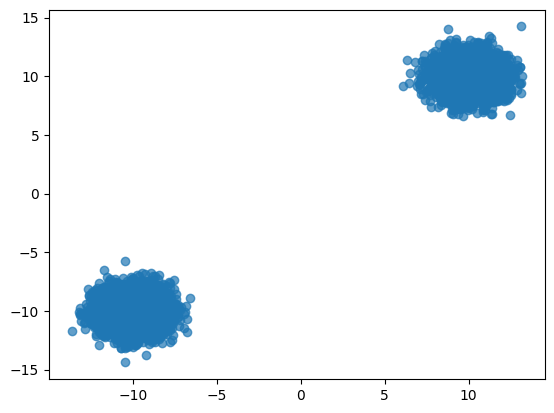

In [9]:
plt.scatter(data[:,0], data[:,1], alpha=0.7)
#plt.hist(data, bins=50, density=True)
plt.show()

## Langevin Dynamics (ULA)

In [10]:
from mcmc import LangevinDynamics

In [11]:
def multichain_sample(sampler: eqx.Module, dim: int, key: jax.random.PRNGKey, n_chains: int = 1000, init_std: float = 5):
    starter_points = jax.random.normal(key, shape=(n_chains, 1, dim)) * init_std
    starter_keys = jax.random.split(key, n_chains)

    _, samples = jax.vmap(sampler)(starter_points, starter_keys)
    samples = samples.reshape(-1, dim)
    return samples

In [12]:
rng, key = jax.random.split(rng)
sampler = LangevinDynamics(gradient_func=grad_log_p, n_samples=500, gamma=1e-2, burnin_steps=100)
samples = multichain_sample(sampler, dist_dim, key, n_chains = 100)

In [1]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.7)
print(jnp.any(np.isnan(samples)))
#plt.hist(samples, bins=50, density=True)
plt.show()

NameError: name 'plt' is not defined

## Baseline
Using a sample mean as an integral estimate

In [14]:
def mcmc_baseline(fn: tp.Callable, sampler: eqx.Module, dim: int, key: jax.random.PRNGKey, n_chains: int = 1000):
    samples = multichain_sample(sampler, dim, key, n_chains)
    return jax.vmap(fn)(samples).mean()

In [15]:
fn = jax.jit(lambda x: x.sum(axis=-1))

100%|██████████| 1000/1000 [00:29<00:00, 33.79it/s]


False


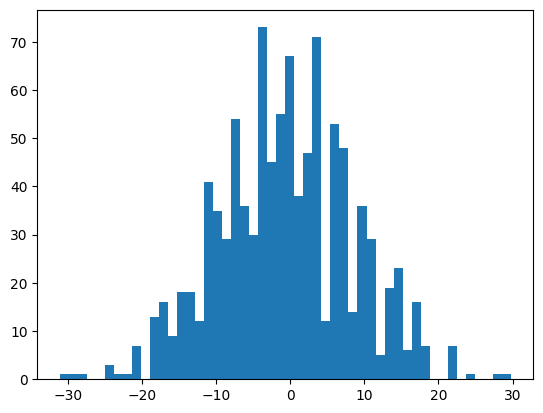

In [16]:
n_runs = 1000

# Run without vmap because of OOM
mcmc_estimates = []
for key in tqdm(jax.random.split(rng, n_runs)):
    mcmc_estimates.append(mcmc_baseline(fn, sampler, dist_dim, key, n_chains = 100))   
mcmc_estimates = jnp.stack(mcmc_estimates)

print(jnp.any(jnp.isnan(mcmc_estimates)))
plt.hist(mcmc_estimates, bins=50)
plt.show()

## Control variates
Train a NN with an objective from "Diffusion Approximations and Control Variates for MCMC"

In [17]:
from diffcv.cv import ControlVariateModel, fit_cv, CVLoss
import jax_dataloader as jdl
from utils import inf_loop

2024-07-22 16:16:06.190041: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 16:16:06.190076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 16:16:06.190101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 16:16:06.932692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
rng, key = jax.random.split(rng)
training_samples = multichain_sample(sampler, dist_dim, key, n_chains = 100)
dataset = jdl.ArrayDataset(training_samples)
dataloader = jdl.DataLoader(
    dataset,
    backend="jax",
    batch_size=1024,
    shuffle=True
)
dataloader = inf_loop(dataloader)
len(dataset)

40000

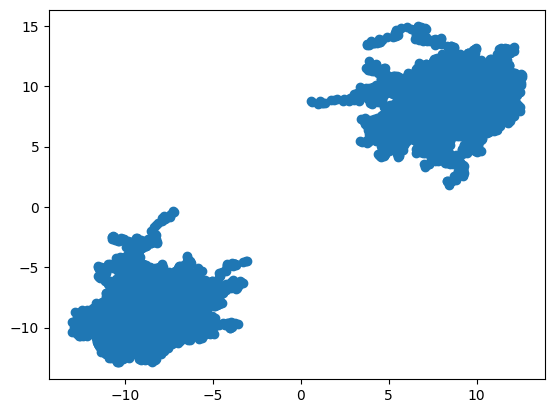

In [19]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

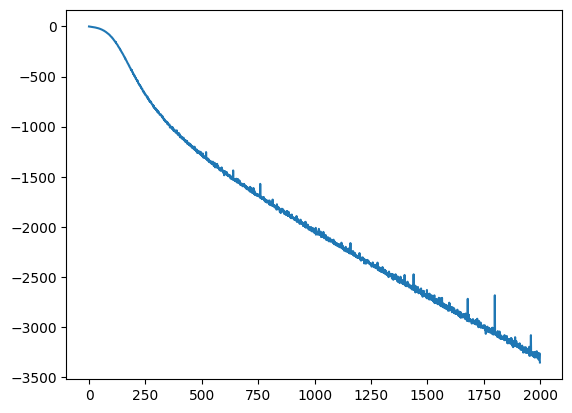

In [20]:
rng, key = jax.random.split(rng)
cv_model = ControlVariateModel(in_size=dist_dim, width_size=128, depth=3, key=key)
optimizer = optax.adam(learning_rate=1e-4)
loss = CVLoss(fn=fn)

cv_model, loss_history = fit_cv(
    cv_model,
    dataloader,  
    optimizer,
    loss, 
    n_steps=2000,
)

plt.plot(loss_history)
plt.show()

In [21]:
# Check NN for nans
rng, key = jax.random.split(rng)
x = jax.random.normal(key, shape=(100, dist_dim))
y = jax.vmap(cv_model)(x)
print(jnp.any(jnp.isnan(y)))

False


In [22]:
from diffcv.cv import Generator

In [23]:
# Expectation of generator with respect to distribution should be 0
generator = Generator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0]).mean()

Array(-8.544824e-06, dtype=float32)

In [24]:
fn_with_cv = lambda x: fn(x) + generator(x)

In [25]:
# Check generator for nans
rng, key = jax.random.split(rng)
x = 1000 * jax.random.normal(key, shape=(100, dist_dim))
y = jax.vmap(generator)(x)
print(np.any(np.isnan(y)))

False


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:45<00:00, 21.91it/s]


False


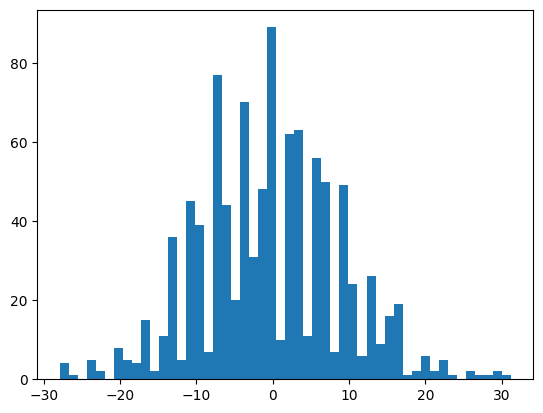

In [26]:
n_runs = 1000

# Run without vmap because of OOM
mcmc_with_cv_estimates = []
for key in tqdm(jax.random.split(rng, n_runs)):
    mcmc_with_cv_estimates.append(mcmc_baseline(fn_with_cv, sampler, dist_dim, key, n_chains = 100))   
mcmc_with_cv_estimates = np.stack(mcmc_with_cv_estimates)

print(np.any(np.isnan(mcmc_with_cv_estimates)))
plt.hist(mcmc_with_cv_estimates, bins=50)
plt.show()

In [27]:
mcmc_estimates.mean(), mcmc_estimates.std()

(Array(-0.6332459, dtype=float32), Array(9.027302, dtype=float32))

In [28]:
mcmc_with_cv_estimates.mean(), mcmc_with_cv_estimates.std()

(-0.33234212, 9.26594)

## Control variates (ALS Style)

In [29]:
rng, key = jax.random.split(rng)
training_samples = multichain_sample(sampler, dist_dim, key, n_chains = 100)
dataset = jdl.ArrayDataset(training_samples)
dataloader = jdl.DataLoader(
    dataset,
    backend="jax",
    batch_size=1024,
    shuffle=True
)
dataloader = inf_loop(dataloader)
len(dataset)

40000

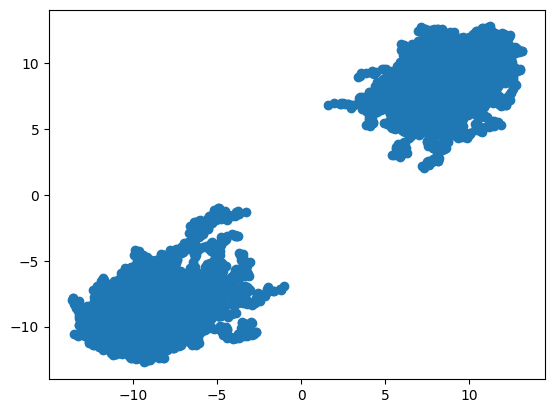

In [30]:
plt.scatter(x=dataset.arrays[0][:, 0], y=dataset.arrays[0][:, 1])
#plt.hist(dataset.arrays[0], bins=50)
plt.show()

In [31]:
from diffcv.cv import Generator, CVALSLoss

  0%|          | 0/2000 [00:00<?, ?it/s]

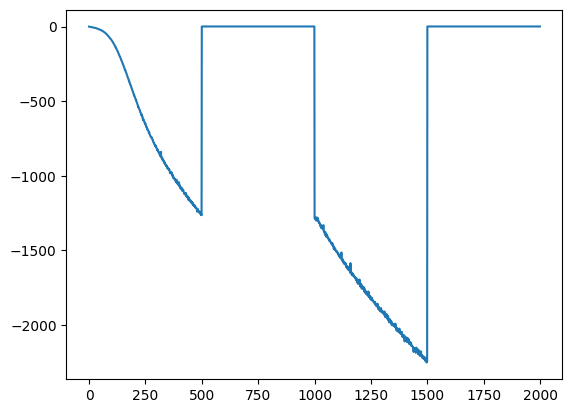

In [32]:
rng, key = jax.random.split(rng)
cv_model = ControlVariateModel(in_size=dist_dim, width_size=128, depth=3, key=key)
optimizer = optax.adam(learning_rate=1e-4)

loss = CVALSLoss(fn=fn, grad_log_p=grad_log_p, switch_steps=500)

cv_model, loss_history = fit_cv(
    cv_model,
    dataloader,  
    optimizer,
    loss, 
    n_steps=2000,
)

plt.plot(loss_history)
plt.show()


In [33]:
generator = Generator(grad_log_p, cv_model)
jax.vmap(generator)(dataset.arrays[0]).mean()

Array(-5.7571738e-06, dtype=float32)

In [34]:
fn_with_cv = lambda x: fn(x) + generator(x)

100%|██████████| 1000/1000 [00:44<00:00, 22.45it/s]


False


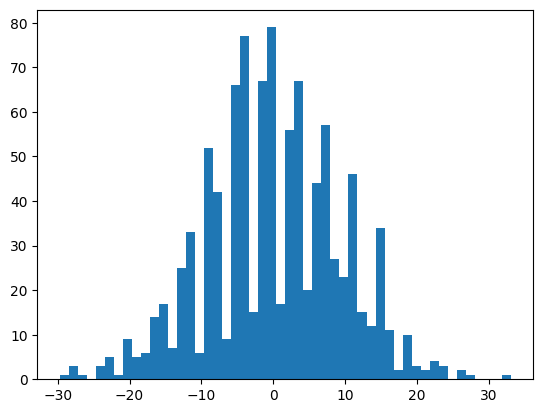

In [35]:
n_runs = 1000

# Run without vmap because of OOM
mcmc_with_cv_als_estimates = []
for key in tqdm(jax.random.split(rng, n_runs)):
    mcmc_with_cv_als_estimates.append(mcmc_baseline(fn_with_cv, sampler, dist_dim, key, n_chains = 100))   
mcmc_with_cv_als_estimates = np.stack(mcmc_with_cv_als_estimates)

print(np.any(np.isnan(mcmc_with_cv_als_estimates)))
plt.hist(mcmc_with_cv_als_estimates, bins=50)
plt.show()

In [36]:
mcmc_estimates.mean(), mcmc_estimates.std()

(Array(-0.6332459, dtype=float32), Array(9.027302, dtype=float32))

In [37]:
mcmc_with_cv_estimates.mean(), mcmc_with_cv_estimates.std()

(-0.33234212, 9.26594)

In [38]:
mcmc_with_cv_als_estimates.mean(), mcmc_with_cv_als_estimates.std()

(0.018209778, 9.400666)